In [0]:
import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable


from google.colab import files

In [0]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 4,padding=2)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, 4,padding=2)
        self.pool = nn.MaxPool2d(2,2)
        self.conv_drop = nn.Dropout(p=0.25)
        self.conv3 = nn.Conv2d(64, 64, 4,padding=2)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, 4,padding=2)
        self.conv5 = nn.Conv2d(64, 64,4,padding=2)
        self.bn5 = nn.BatchNorm2d(64)
        self.conv6 = nn.Conv2d(64,64,3,padding=0)
        self.conv7 = nn.Conv2d(64,64,3,padding=0)
        self.bn7 = nn.BatchNorm2d(64)
        self.conv8 = nn.Conv2d(64,64,3,padding=0)
        self.bn8 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64*4*4, 500)
        self.fc2 = nn.Linear(500,500)
        self.fc3 = nn.Linear(500,128)
        self.fc4 = nn.Linear(128,10)
        self.fc_drop = nn.Dropout(p=0.5)

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x)),negative_slope=0.1)
        x = F.leaky_relu(self.pool(self.conv2(x)),negative_slope=0.1)
        x = self.conv_drop(x)
        x = F.leaky_relu(self.bn3(self.conv3(x)),negative_slope=0.1)
        x = F.leaky_relu(self.pool(self.conv4(x)),negative_slope=0.1)
        x = self.conv_drop(x)
        x = F.leaky_relu(self.bn5(self.conv5(x)),negative_slope=0.1)
        x = F.leaky_relu(self.conv6(x),negative_slope=0.1)
        x = self.conv_drop(x)
        x = F.leaky_relu(self.bn7(self.conv7(x)),negative_slope=0.1)
        x = F.leaky_relu(self.bn8(self.conv8(x)),negative_slope=0.1)
        x = self.conv_drop(x)
        x = x.view(x.size(0), -1)
        x = x.view(-1,64*4*4)
        x = F.leaky_relu(self.fc1(x),negative_slope=0.1)
        x = F.leaky_relu(self.fc2(x),negative_slope=0.1)
        x = F.leaky_relu(self.fc3(x),negative_slope=0.1)
        x = self.fc4(x)
        return x

In [0]:
class Model_Trainer():
    def __init__(self,model,classes,criterion,optimizer,batchSize,trainset,testset):
        self.model = model
        self.classes = classes
        self.criterion = criterion
        self.optimizer = optimizer
        self.trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchSize,
                            shuffle=True, num_workers=2)
        self.testloader = torch.utils.data.DataLoader(testset, batch_size=batchSize,
                            shuffle=False, num_workers=2)
        self.epoch_num_trained = 0
        self.costs = []
        self.costs_step = []
        self.test_accus = []
        self.train_accus =[]
    
    def train(self,n_epochs):
        for epoch in range(n_epochs):
            self.model.train()
            cost = 0
            a = len(self.trainloader)
            for i, data in enumerate(self.trainloader, 0):
                inputs, labels = data
                inputs = Variable(inputs).cuda()
                labels = Variable(labels).cuda()
                
                
                self.optimizer.zero_grad()

                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                #cost += loss.data/a
                cost += loss.item()/a
            self.epoch_num_trained +=1
            if (self.epoch_num_trained)%(2) == 0 or epoch==0:              
                print (str(self.epoch_num_trained),cost)
                self.costs.append(cost)
                self.costs_step.append(self.epoch_num_trained)
        self.costs.append(cost)
        self.costs_step.append(self.epoch_num_trained)
        return 
    
    def test_accu(self):
        
        correct = 0
        total = 0
        class_correct = list(0. for i in range(10))
        class_total = list(0. for i in range(10))
        self.model.eval()
        with torch.no_grad():
            for data in self.testloader:
                images, labels = data
                images = Variable(images).cuda()
                labels = Variable(labels).cuda()
                outputs = self.model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
               
        return 100.0*correct/total
    
    def train_accu(self):
        correct = 0
        total = 0
        self.model.eval()
        with torch.no_grad():
            for data in self.trainloader:
                images, labels = data
                images = torch.autograd.Variable(images).cuda()
                labels = torch.autograd.Variable(labels).cuda()
                outputs = self.model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
        return 100.0*correct/total
        

In [6]:
transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.RandomCrop(32),
     transforms.RandomRotation(20),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified


In [0]:
mynet = Model().cuda()
criterion = nn.CrossEntropyLoss()
alpha = 0.001
optimizer = optim.Adam(mynet.parameters(),lr = alpha)
batch_size=128
mynet_trainer = Model_Trainer(mynet,classes,criterion,optimizer,batch_size,trainset,testset)

In [8]:
mynet_trainer.train(50)

1 1.5619897293617655
2 1.1955799748525588
4 0.9208091744376572
6 0.795840575414545
8 0.7170457934479578
10 0.659285293744348
12 0.6193800724833208
14 0.5813512772397923
16 0.5621555051992619
18 0.5352954472727178
20 0.5144863957181915
22 0.49351993386093
24 0.47765185255223835
26 0.4656041994729006
28 0.45255217055225644
30 0.4345644596211439
32 0.43022590738428207
34 0.41177463287587673
36 0.41005695506434897
38 0.394619553900131
40 0.3845349130651837
42 0.3787148024724878
44 0.37212874448817723
46 0.3661704885837674
48 0.35760109991673616
50 0.356255403603129


In [0]:
torch.save(mynet.state_dict(),"model.parameter" )
files.download("model.parameter")

In [10]:
mynet_trainer.train_accu()

90.724

In [11]:
#mynet_trainer = Model_Trainer(mynet,classes,criterion,optimizer,batch_size,trainset,testset)
mynet_trainer.test_accu()

85.13

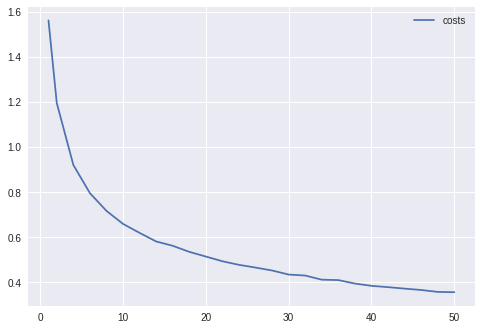

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files

#plt.plot(np.arange(len(mynet_trainer.test_accus))*2.,mynet_trainer.test_accus,label="test accu")
plt.plot(mynet_trainer.costs_step,mynet_trainer.costs,label="costs")
plt.legend(loc="best")
plt.savefig("config.png")
files.download("config.png")
plt.show()

In [0]:
import numpy as np
def Monte_Carlo_test(model_trainer,MC_size,images):
  model = model_trainer.model
  model.train()
  outs = np.zeros((MC_size,128,10))
  for i in range(MC_size):
    with torch.no_grad():
      images = torch.autograd.Variable(images).cuda()
      outputs = model(images)
      outputs = outputs.cpu().numpy()
      expouts = np.exp(outputs)
      outputs = expouts/(np.sum(expouts,axis=1,keepdims=True))
      outs[i,:,:] = outputs[:,:]
  out = np.sum(outs,axis=0)/MC_size
  return out
    
def Evaluate(model_trainer,MC_size,images):
  model = model_trainer.model
  model.eval()
  outs = np.zeros((128,10))
  with torch.no_grad():
    images, labels = data
    images = torch.autograd.Variable(images).cuda()
    outputs = model(images)
    outputs = outputs.cpu().numpy()
    expouts = np.exp(outputs)
    outs[:,:] = expouts/(np.sum(expouts,axis=1,keepdims=True))
  return outs

In [0]:
for i, data in enumerate(mynet_trainer.trainloader, 0):
  images, labels = data
  break
MCout = Monte_Carlo_test(mynet_trainer,100,images)
Myout = Evaluate(mynet_trainer,1000,images)


0.9765625


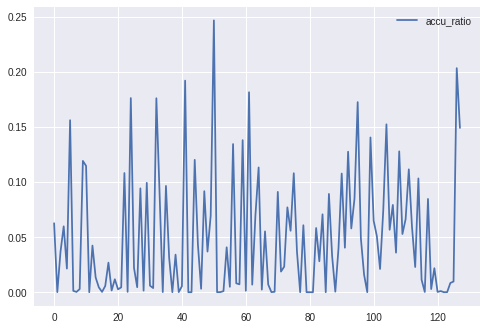

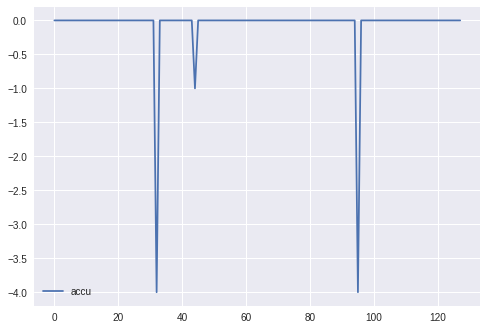

In [20]:
import matplotlib.pyplot as plt
diff = np.linalg.norm(Myout-MCout,ord=np.inf,axis=1)
accu = np.linalg.norm(MCout,ord=1,axis=1)
outs = np.linalg.norm(Myout,ord=1,axis=1)
accu_ratio = diff/accu


plt.figure()
plt.plot(accu_ratio,label="accu_ratio")
plt.legend()


plt.figure()
accu = np.argmax(MCout,axis=1)
outs = np.argmax(Myout,axis=1)
plt.plot(accu-outs,label="accu")
plt.legend()
plt.savefig("mctest.png")
files.download("mctest.png")
print (1.*np.sum(accu==outs)/accu.shape[0])